In [2]:
!pip install PyPDF2
import PyPDF2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import LatentDirichletAllocation
from wordcloud import WordCloud
import nltk
from nltk.corpus import stopwords
import warnings
warnings.filterwarnings('ignore')

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 232.6/232.6 kB 7.5 MB/s eta 0:00:00


In [3]:
# Descargar stopwords en español
nltk.download('stopwords')
stop_words_es = stopwords.words('spanish')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [4]:
def extraer_texto_pdf(ruta_pdf):
    """Extrae todo el texto de un archivo PDF"""
    texto = ""
    try:
        with open(ruta_pdf, 'rb') as archivo:
            lector = PyPDF2.PdfReader(archivo)
            print(f"Número de páginas: {len(lector.pages)}")

            for pagina in lector.pages:
                texto += pagina.extract_text()

        print(f"Caracteres extraídos: {len(texto)}")
        return texto
    except Exception as e:
        print(f"Error al leer {ruta_pdf}: {e}")
        return ""

In [5]:
print("=" * 50)
print("EXTRAYENDO TEXTO DE LOS PDFs")
print("=" * 50)

pdf1 = "/content/CARTILLA_DERECHO_DISCIPLINARIO-7-18.pdf"
pdf2 = "/content/Manual-de-escritura-jurídica-6-17 (1).pdf"

print("\n📄 Procesando PDF 1...")
texto1 = extraer_texto_pdf(pdf1)

print("\n📄 Procesando PDF 2...")
texto2 = extraer_texto_pdf(pdf2)


EXTRAYENDO TEXTO DE LOS PDFs

📄 Procesando PDF 1...
Número de páginas: 12
Caracteres extraídos: 21309

📄 Procesando PDF 2...
Número de páginas: 12
Caracteres extraídos: 68272


In [6]:
# PASO 5: Calcular TF-IDF
# ============================================
print("\n" + "=" * 50)
print("CALCULANDO TF-IDF")
print("=" * 50)

# Crear vectorizador TF-IDF
vectorizador = TfidfVectorizer(
    max_features=100,  # Top 100 términos
    stop_words=stop_words_es,
    min_df=1,
    max_df=0.8,
    ngram_range=(1, 2)  # Unigramas y bigramas
)

# Vectorizar los documentos
documentos = [texto1, texto2]
nombres_docs = ["Derecho Disciplinario", "Escritura Jurídica"]

matriz_tfidf = vectorizador.fit_transform(documentos)
terminos = vectorizador.get_feature_names_out()

print(f"\n✅ Matriz TF-IDF creada: {matriz_tfidf.shape}")
print(f"   Documentos: {matriz_tfidf.shape[0]}")
print(f"   Términos únicos: {matriz_tfidf.shape[1]}")



CALCULANDO TF-IDF

✅ Matriz TF-IDF creada: (2, 100)
   Documentos: 2
   Términos únicos: 100


In [7]:
# PASO 6: Mostrar términos más importantes
# ============================================
print("\n" + "=" * 50)
print("TÉRMINOS MÁS IMPORTANTES POR DOCUMENTO")
print("=" * 50)

for i, nombre in enumerate(nombres_docs):
    print(f"\n📌 {nombre}:")

    # Obtener índices de los términos ordenados por importancia
    scores = matriz_tfidf[i].toarray()[0]
    indices_ordenados = np.argsort(scores)[::-1]

    # Mostrar top 10 términos
    print("   Top 10 términos:")
    for j, idx in enumerate(indices_ordenados[:10], 1):
        print(f"   {j}. {terminos[idx]}: {scores[idx]:.4f}")


TÉRMINOS MÁS IMPORTANTES POR DOCUMENTO

📌 Derecho Disciplinario:
   Top 10 términos:
   1. faltas: 0.5372
   2. cargo: 0.3805
   3. falta: 0.3581
   4. servicio: 0.2910
   5. faltas relacionadas: 0.2462
   6. relacionadas: 0.2462
   7. disciplinaria: 0.2462
   8. públicos: 0.2238
   9. entidad: 0.2014
   10. salvo: 0.1791

📌 Escritura Jurídica:
   Top 10 términos:
   1. escritura: 0.3076
   2. jurídico: 0.2922
   3. abogados: 0.2922
   4. palabras: 0.2153
   5. estilo: 0.2153
   6. jurídica: 0.1923
   7. lengua: 0.1615
   8. lenguaje jurídico: 0.1538
   9. redacción: 0.1538
   10. escritos: 0.1461


In [8]:
# PASO 7: Calcular similitud del coseno
# ============================================
print("\n" + "=" * 50)
print("SIMILITUD DEL COSENO")
print("=" * 50)

similitud = cosine_similarity(matriz_tfidf[0:1], matriz_tfidf[1:2])[0][0]
distancia = 1 - similitud

print(f"\n📊 Similitud del coseno: {similitud:.4f}")
print(f"📊 Distancia del coseno: {distancia:.4f}")
print(f"\n💡 Interpretación:")
print(f"   - Similitud cercana a 1 = documentos muy similares")
print(f"   - Similitud cercana a 0 = documentos muy diferentes")
print(f"   - Estos documentos tienen una similitud del {similitud*100:.2f}%")



SIMILITUD DEL COSENO

📊 Similitud del coseno: 0.0000
📊 Distancia del coseno: 1.0000

💡 Interpretación:
   - Similitud cercana a 1 = documentos muy similares
   - Similitud cercana a 0 = documentos muy diferentes
   - Estos documentos tienen una similitud del 0.00%


In [9]:
# PASO 8: Topic Modeling con LDA
# ============================================
print("\n" + "=" * 50)
print("TOPIC MODELING (LDA)")
print("=" * 50)

# Crear modelo LDA
n_topics = 5
lda = LatentDirichletAllocation(
    n_components=n_topics,
    random_state=42,
    max_iter=20
)

lda.fit(matriz_tfidf)

print(f"\n✅ Modelo LDA entrenado con {n_topics} tópicos\n")

# Mostrar tópicos
print("🔍 TÓPICOS ENCONTRADOS:\n")
for idx, topic in enumerate(lda.components_):
    print(f"Tópico {idx + 1}:")
    top_indices = topic.argsort()[-10:][::-1]
    top_terms = [terminos[i] for i in top_indices]
    print(f"   {', '.join(top_terms)}\n")



TOPIC MODELING (LDA)

✅ Modelo LDA entrenado con 5 tópicos

🔍 TÓPICOS ENCONTRADOS:

Tópico 1:
   disciplinarias, cargo función, salvo, entidad, públicos, faltas relacionadas, relacionadas, disciplinaria, servicio, falta

Tópico 2:
   disciplinarias, cargo función, salvo, entidad, públicos, faltas relacionadas, relacionadas, disciplinaria, servicio, falta

Tópico 3:
   escritura, jurídico, abogados, palabras, estilo, jurídica, lengua, lenguaje jurídico, redacción, escritos

Tópico 4:
   faltas, cargo, falta, servicio, faltas relacionadas, relacionadas, disciplinaria, públicos, entidad, salvo

Tópico 5:
   disciplinarias, cargo función, salvo, entidad, públicos, faltas relacionadas, relacionadas, disciplinaria, servicio, falta



GENERANDO VISUALIZACIONES


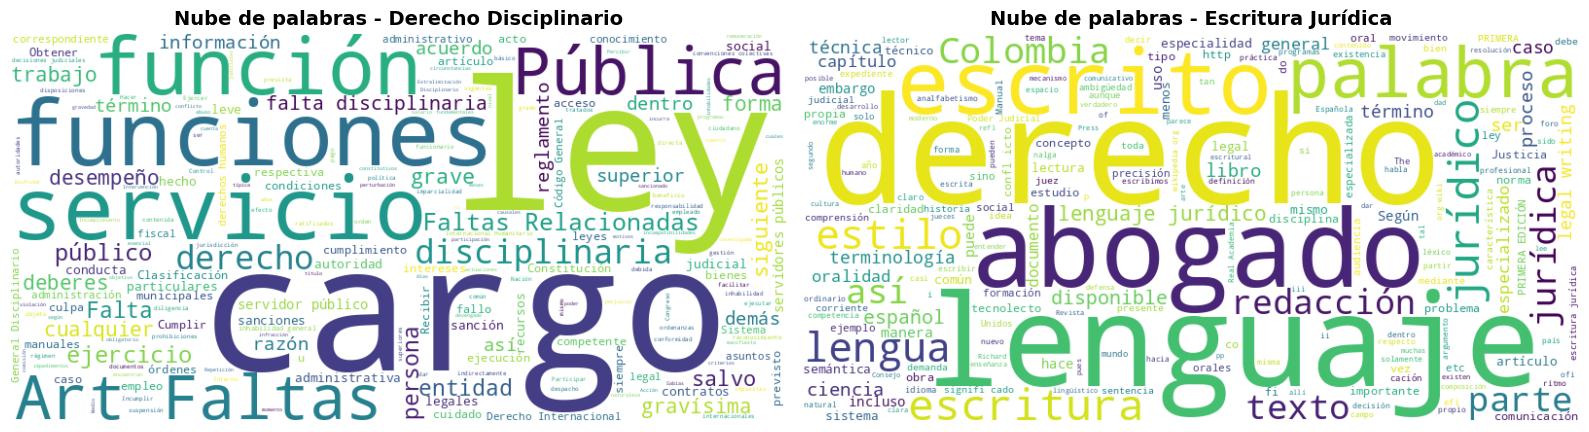


✅ Nube de palabras guardada como 'nubes_palabras.png'


In [10]:
# PASO 9: Visualización - Nube de palabras
# ============================================
print("=" * 50)
print("GENERANDO VISUALIZACIONES")
print("=" * 50)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

for i, (texto, nombre) in enumerate(zip([texto1, texto2], nombres_docs)):
    wordcloud = WordCloud(
        width=800,
        height=400,
        background_color='white',
        stopwords=stop_words_es,
        colormap='viridis'
    ).generate(texto)

    axes[i].imshow(wordcloud, interpolation='bilinear')
    axes[i].set_title(f'Nube de palabras - {nombre}', fontsize=14, fontweight='bold')
    axes[i].axis('off')

plt.tight_layout()
plt.savefig('nubes_palabras.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✅ Nube de palabras guardada como 'nubes_palabras.png'")


In [11]:
extracted_text = extraer_texto_pdf(pdf1)
print(extracted_text[:1000]) # Print first 1000 characters to avoid overwhelming output

Número de páginas: 12
Caracteres extraídos: 21309
2.1.Definición de la falta
disciplinaria
La falta disciplinaria es aquella
conducta que perturba la buena
marcha de la Función Pública
que conlleve a:
·Incumplimiento de deberes, 
·Extralimitación en el ejercicio de
derechos y funciones, 
·Prohibiciones y violación del
régimen de inhabilidades,
incompatibilidades,
impedimentos y conflicto de
intereses; 
Sin estar amparado por
cualquiera de las causales de
exclusión de responsabilidad
contempladas en esta ley.
¿Sabías que las faltas solo
son sancionables a título de
dolor o culpa, ¿qué significa
esto?La conducta es culposa cuando el
sujeto disciplinable incurre en los
hechos constitutivos de falta
disciplinaria, por la infracción
al deber objetivo de cuidado
funcionalmente exigible y debió
haberla previsto por ser previsible
o habiéndola previsto confió en
poder evitarla.
La conducta es dolosa
cuando el sujeto
disciplinable conoce los
hechos constitutivos de
falta disciplinaria.CULPA.
GR

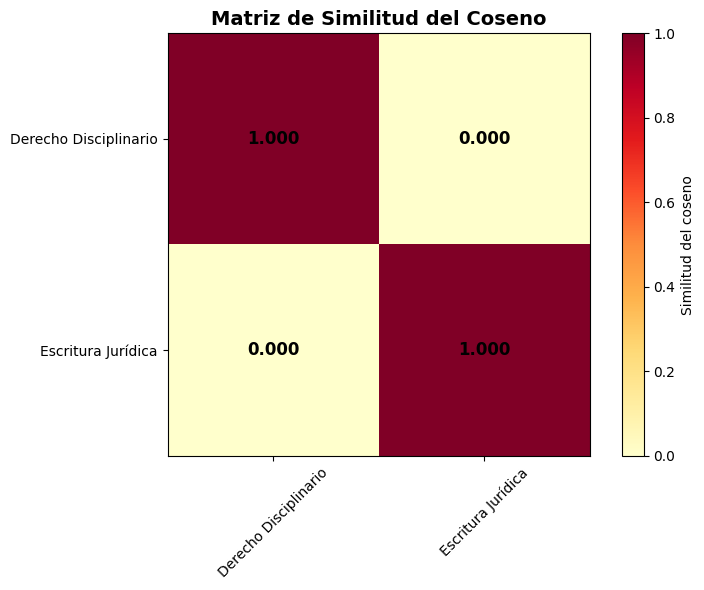

✅ Matriz de similitud guardada como 'matriz_similitud.png'


In [12]:
# PASO 10: Visualización - Matriz de similitud
# ============================================
matriz_similitud = cosine_similarity(matriz_tfidf)

plt.figure(figsize=(8, 6))
plt.imshow(matriz_similitud, cmap='YlOrRd', interpolation='nearest')
plt.colorbar(label='Similitud del coseno')
plt.xticks([0, 1], nombres_docs, rotation=45)
plt.yticks([0, 1], nombres_docs)
plt.title('Matriz de Similitud del Coseno', fontsize=14, fontweight='bold')

# Añadir valores en las celdas
for i in range(len(nombres_docs)):
    for j in range(len(nombres_docs)):
        plt.text(j, i, f'{matriz_similitud[i, j]:.3f}',
                ha='center', va='center', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.savefig('matriz_similitud.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Matriz de similitud guardada como 'matriz_similitud.png'")

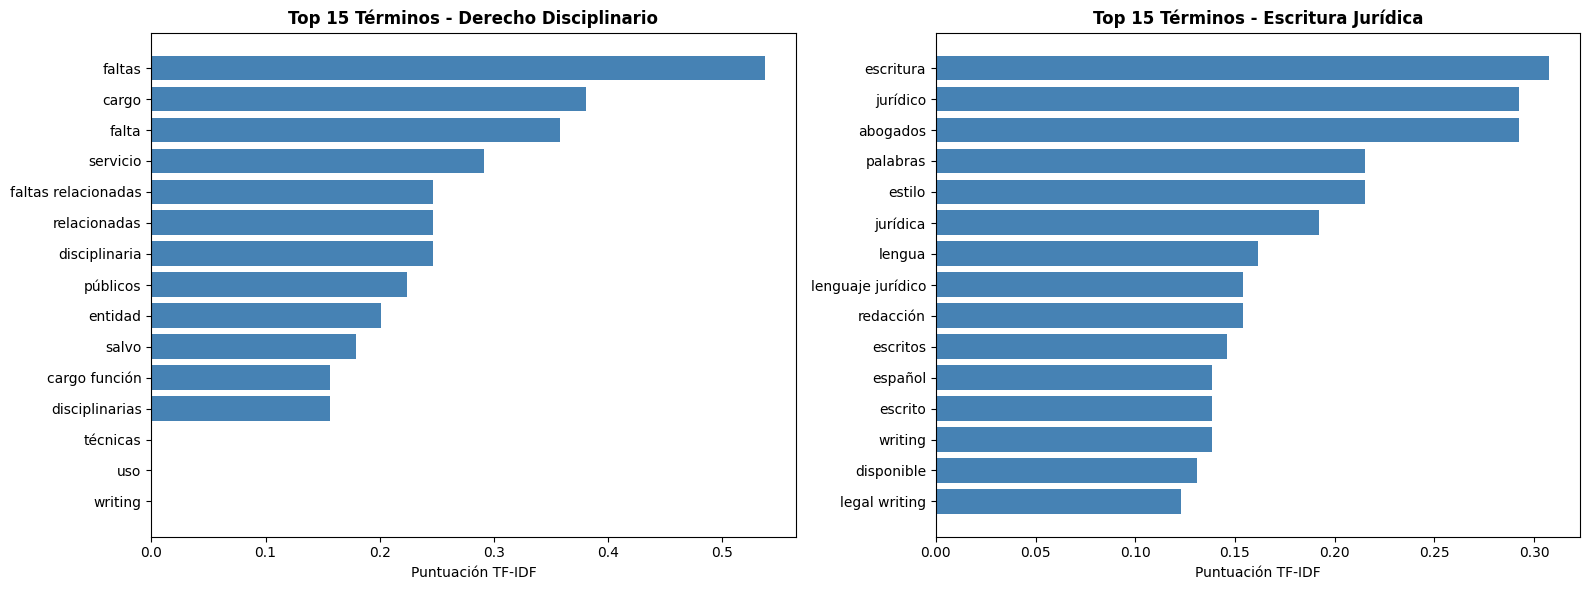

✅ Gráfico de términos guardado como 'top_terminos.png'


In [13]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

for i, nombre in enumerate(nombres_docs):
    scores = matriz_tfidf[i].toarray()[0]
    indices_ordenados = np.argsort(scores)[::-1][:15]

    top_terms = [terminos[idx] for idx in indices_ordenados]
    top_scores = [scores[idx] for idx in indices_ordenados]

    axes[i].barh(range(len(top_terms)), top_scores, color='steelblue')
    axes[i].set_yticks(range(len(top_terms)))
    axes[i].set_yticklabels(top_terms)
    axes[i].set_xlabel('Puntuación TF-IDF', fontsize=10)
    axes[i].set_title(f'Top 15 Términos - {nombre}', fontsize=12, fontweight='bold')
    axes[i].invert_yaxis()

plt.tight_layout()
plt.savefig('top_terminos.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Gráfico de términos guardado como 'top_terminos.png'")


In [14]:
# RESUMEN FINAL
# ============================================
print("\n" + "=" * 50)
print("📋 RESUMEN FINAL")
print("=" * 50)
print(f"""
✓ Documentos analizados: 2
✓ Términos únicos extraídos: {len(terminos)}
✓ Tópicos identificados: {n_topics}
✓ Similitud entre documentos: {similitud:.4f}
✓ Distancia del coseno: {distancia:.4f}

📁 Archivos generados:
   - nubes_palabras.png
   - matriz_similitud.png
   - top_terminos.png
""")


📋 RESUMEN FINAL

✓ Documentos analizados: 2
✓ Términos únicos extraídos: 100
✓ Tópicos identificados: 5
✓ Similitud entre documentos: 0.0000
✓ Distancia del coseno: 1.0000

📁 Archivos generados:
   - nubes_palabras.png
   - matriz_similitud.png
   - top_terminos.png

